# Data analysis with SciAnalysis

last updated: 2023 May

In this notebook, we can load the raw tiff, load or extract metedata, analysis the data, save the analysis results and metadata in .H5.

--------------------------------------

*exp.dict*: The experiment dictionary. 'Experiment' is a series of measurements, e.g. in-situ thermal annealing measurements of a sample.

*exp.dict.keys()*: ['analysis', 'corr', 'corrdata', 'data', 'detector', 'exp_protocol', 'expinfo', 'expname', 'folder', 'mdata_list', 'metadata']

--------------------------------------

# &#9635; SciAnalysis for Experiment

At home insitute, download SciAnalysis at: https://github.com/CFN-softbio/SciAnalysis



In [2]:
#%matplotlib nbagg
# Imports
########################################
import sys, os, time, glob, imageio, datetime, pprint, math
import sqlite3
import pandas as pd
from silx.io.dictdump import dicttoh5, h5todict

SciAnalysis_PATH='/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/' ### Specify this
SciAnalysis_PATH in sys.path or sys.path.append(SciAnalysis_PATH)

from SciAnalysis import tools
from SciAnalysis.XSAnalysis.Data import *
from SciAnalysis.XSAnalysis import Protocols

from SciAnalysis.ExpAnalysis import Experiment
from SciAnalysis.ExpAnalysis import Tools

now = datetime.datetime.now()
dt_string = now.strftime("%Y/%m/%d %H:%M:%S")
print("{}\n".format(dt_string))

# %pwd

2023/07/03 16:21:53



## 0. Calibration

__Direct beam (if available)__

__Calibration: Energy, beam center, SD distance__

1. Specify wavelength 
2. Tweak beam center and SD distance to get the best match for the calibrant

__Convert between q and angle__

## 1. Raw data

## Notes for KWhite data in 2023C2

### Use samplefolder and scanid to load the series_measure data `exp.defFiles_ScanID_ONLY`

### The scanid is read from the terminal!


In [5]:
### Specify sample folder and scanid of interest

# samplefolder_load = 'sam98_3mai1pbi2_1dmf1dmso_1m_5scfh_Si_40uL_012'
# scanid = 1116276

samplefolder_load = 'pybtz_CB_15_200_40_60_60_011'
scanid = 1117894

In [6]:
if 1: 
    # EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite/' 
    # samplefolder_load = 'sam99_1mai1pbi2_1dmf1dmso_1m_5scfh_Si_40uL_011' # sam16_3mai1pbi2_dmf_1m_5scfh_Si_40uL_010
#     # scanid = 1116248
    
#     samplefolder_load = 'sam98_3mai1pbi2_1dmf1dmso_1m_5scfh_Si_40uL_012' # sam16_3mai1pbi2_dmf_1m_5scfh_Si_40uL_010
    # scanid = scanid - 1
    # EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite/'  + samplefolder_load + '/'
    EXPR_DIR = '/nsls2/data/cms/proposals/2023-2/pass-311415/KWhite5/'  + samplefolder_load + '/'
    exp = Experiment.experiment(samplefolder_load, folder=EXPR_DIR, det='maxs', series_measure=True, beamline='cms') ##Experiment name: rbitrary or related to the sample name
    exp.dict['expinfo']['fn_patterns'] = [f'{samplefolder_load}*']  


### Load files
try:
    for pattern in exp.dict['expinfo']['fn_patterns']:
        #exp.defFiles_query(fn='PBG', folder=EXPR_DIR, scanid = [900000, 1200000], verbose=1) 
        print(f'pattern = {pattern}')
        # exp.defFiles(fn=pattern, verbose=1) 
        # exp.defFiles(fn=pattern, scanid = [750000, 900000], verbose=1)  
        # infiles = exp.defFiles_ScanID_ONLY(fn=pattern, scanid = [1116002], verbose=1)  
        infiles = exp.defFiles_ScanID_ONLY(fn=pattern, scanid = [scanid], verbose=1)  
        
    # infiles = exp.dict['rawinfo']['filename']
    Nfiles = len(infiles)
    
except:
    print('\n!!! Databroker not working, loading files directly.')
    #exp.dict['expinfo']['beamline'] = None
    for pattern in exp.dict['expinfo']['fn_patterns']:
        infiles = exp.defFiles_ScanID_ONLY(fn=pattern, scanid = [scanid], verbose=1)  
    

### Show some info   
exp.show()
exp.showFileInfo(idx=0)

pattern = pybtz_CB_15_200_40_60_60_011*
/nsls2/data/cms/proposals/2023-2/pass-311415/KWhite5/pybtz_CB_15_200_40_60_60_011/maxs/raw/


OBJECT CACHE: Will use up to 121_499_065_958 bytes (15% of total physical RAM)



!!! Databroker not working, loading files directly.
/nsls2/data/cms/proposals/2023-2/pass-311415/KWhite5/pybtz_CB_15_200_40_60_60_011/maxs/raw/


OBJECT CACHE: Will use up to 121_499_065_958 bytes (15% of total physical RAM)


KeyError: 'No match for partial_uid 1117894'

## 2. Metadata

In [271]:
## Options: (1) load metadata from databroker at beamline. (2) load md from h5. (3) Extract info from filename
md_load_option = 1

## Clear all metadata
exp.dict['metadata'] = {}


## Load metadata
if md_load_option==1: # Load md from databroker, this only works at beamline
    exp.dict['mdata_list'] = ['scan_id'] # Specify metedata to load
    exp.loadMetadata()
    print(exp.dict['metadata'].keys())
    
elif md_load_option==2: # Load md from h5 (previously saved from databroker)
    h5_path = EXPR_DIR+"/data/"
    h5_file = 'B6_N3_metadata.h5'
    exp.dict['metadata'] = h5todict(h5_path+h5_file)


elif md_load_option==3: ## If databroker md is not available nor saved
    infiles = exp.dict['rawinfo']['filename']
    print('Number of files: {}'.format(len(infiles)))

    Ts = []
    sample_x = []
    sample_y = []
    scan_id = []
    frames = []
    for ii, infile in enumerate(infiles):
        temp = infile.split('_')
        if ii==0: print(temp)
        
        Ts.append(float(infile.split('Linkam')[1].split('C')[0]))
        #sample_x.append(float(temp[-4][1:]))
        #sample_y.append(float(temp[-3][1:]))
        
        #Ts.append(float(infile.split('RH')[1].split('_x')[0]))
        #scan_id.append(int(temp[-1]))
        #frames.append(int(temp[-1]))

    exp.dict['metadata']['sample_temperature_D'] = Ts
    #exp.dict['metadata']['sample_x'] = np.array(sample_x)
    #exp.dict['metadata']['sample_y'] = np.array(sample_y)
    #exp.dict['metadata']['frames'] = frames
    
    print(exp.dict['metadata'].keys())

else:
    print('No metadata loaded to the exp. dictionary!')

[0%] 
[7%] 
[13%] 
[20%] 
[26%] 
[33%] 
[40%] 
[46%] 
[53%] 
[60%] 
[66%] 
[73%] 
[79%] 
[86%] 
[93%] 
[99%] 
(loadMetadata time = 2.5s)
dict_keys(['scan_id'])


## 3. Analysis

We suspect that loading analysis results is slow, faster if processing raw data. However, going through the protocals is also slow; storing it to the exp.dict also takes a bit time.

E.g. 3600 files, 1 protocol, saving to exp.dict: 5min

In [273]:
### Specify beamline config (e.g. beam energy, center, det-sample distance)




if 1: #WAXS, MAXS
    #calibration = Calibration(wavelength_A=0.7293) # 17 keV
    calibration = Calibration(wavelength_A=12.4/12.7) #12.7 keV
    calibration.set_image_size(981, height=1043) # Pilatus1M
    calibration.set_pixel_size(pixel_size_um=172.0)
    
    calibration.set_beam_position(577, 1043-389) # Pilatus 800k x=450 y=398 works in xi-cam, in scianalysis need y=1043-398=645
    calibration.set_distance(0.234)

    ## LRichter
    if 0:
        calibration.set_beam_position(543, 606) #LRichter
        calibration.set_distance(0.2815)
    
    mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
    mask = Mask(mask_dir+'Dectris/Pilatus800k2_gaps-mask.png')
    mask.load('./Pilatus800k2_custom-mask.png')

  
    
load_args = { 'calibration' : calibration, 
             'mask' : mask,
             #'rot180' : False,
             #'flip' : True, # PSCCD
             }
run_args = { 'verbosity' : 3,
            #'save_results' : ['xml', 'plots', 'txt', 'hdf5'],
            }
process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)


### Run analysis 
protocols = ['circular_average'] #['linecut_angle'] #['circular_average'] #, 'sector_average', 'linecut_qz']

exp.dict['analysis']['cali'] = [calibration.wavelength_A, calibration.x0, calibration.y0, calibration.distance_m]
#exp.dict['analysis'] = {} 
#for protocol in protocols:
#    exp.dict['analysis'][protocol] = {}

t0 = time.time()  
    
line_y_stack = []
for protocol in protocols:
    if 'circular_average' in protocol:
        for ii, infile in enumerate(infiles):
            if np.mod(ii+1, 50)==0: print('[{:.0f}%]'.format(ii/Nfiles*100))

            det = exp.dict['expinfo']['det']
            folder = exp.dict['expinfo']['folder']

            # infile_fullpath = folder+'/'+det+'/raw/'+exp.dict['rawinfo']['filename'][ii]+'_'+det+'.tiff'
            infile_fullpath = infile
            # print(infile_fullpath)
            data = process.load(infile_fullpath, calibration=calibration, mask=mask, run_args=run_args)

            ### Run the protocol
            line_output = data.circular_average_q_bin(error=False)
            line_y_stack.append(line_output.y)

            if 0:
                exp.dict['analysis'][protocol][str(ii)] = {}
                exp.dict['analysis'][protocol][str(ii)]['q'] = line_output.x
                exp.dict['analysis'][protocol][str(ii)]['I(q)'] = line_output.y
        
        ### Save analysis to exp.dict
        if 1:
            exp.dict['analysis'][protocol] = {}
            exp.dict['analysis'][protocol]['q'] = line_output.x
            exp.dict['analysis'][protocol]['I_stack'] = line_y_stack   
            #x = Protocols.thumbnails(name=None) 
            #x.run(data, output_dir)
            
    if 'linecut_qr' in protocol:
        for ii, infile in enumerate(infiles):
            if np.mod(ii+1, 50)==0: print('[{:.0f}%]'.format(ii/Nfiles*100))

            det = exp.dict['expinfo']['det']
            folder = exp.dict['expinfo']['folder']

            infile_fullpath = folder+'/'+det+'/raw/'+exp.dict['rawinfo']['filename'][ii]+'_'+det+'.tiff'
            data = process.load(infile_fullpath, calibration=calibration, mask=mask, run_args=run_args)

            ### Run the protocol
            line_output = data.linecut_qr(qz=0.03, dq=0.003)
            line_y_stack.append(line_output.y)

        ### Save analysis to exp.dict
        if 1:
            exp.dict['analysis'][protocol] = {}
            exp.dict['analysis'][protocol]['q'] = line_output.x
            exp.dict['analysis'][protocol]['I_stack'] = line_y_stack           
        
    #elif 'sector_average' in protocol: 
    #    line_output = data.sector_average_q_bin(angle=60, dangle=5)

    #elif 'linecut_qz' in protocol:
    #    line_output = data.linecut_qz(qr=0, dq=0.05)

    #elif 'linecut_angle' in protocol:
    #line_output = data.linecut_angle(q0=2.24, dq=0.01)
            
        
print('Done! (Analysis took {:.0f}s)\n'.format(time.time()-t0))

now = datetime.datetime.now()
dt_string = now.strftime("%Y/%m/%d %H:%M:%S")
print("{}\n".format(dt_string))

print(exp.dict['analysis'].keys())

[2%]
[3%]
[5%]
[7%]
[8%]
[10%]
[12%]
[13%]
[15%]
[17%]
[18%]
[20%]
[21%]
[23%]
[25%]
[26%]
[28%]
[30%]
[31%]
[33%]
[35%]
[36%]
[38%]
[40%]
[41%]
[43%]
[45%]
[46%]
[48%]
[50%]
[51%]
[53%]
[55%]
[56%]
[58%]
[60%]
[61%]
[63%]
[64%]
[66%]
[68%]
[69%]
[71%]
[73%]
[74%]
[76%]
[78%]
[79%]
[81%]
[83%]
[84%]
[86%]
[88%]
[89%]
[91%]
[93%]
[94%]
[96%]
[98%]
[99%]
Done! (Analysis took 62s)

2023/07/02 13:42:32

dict_keys(['cali', 'circular_average'])


## 4. Save 

Save experiment dictionary (exp.dict) to h5.

In [249]:
# h5_path = EXPR_DIR+"/data/"

h5_path = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite5/'+"/data/"


h5_file = str(exp.dict['expinfo']['expname']) + '_cms_exp.h5'
output_file = h5_path+h5_file


## Check if file exist, will not overwrite
if False:
    file_exist = os.path.isfile(output_file)
    count = 1
    while file_exist:
        print('{} exists, using a new filename'.format(output_file))
        h5_file = str(exp.dict['expname']) + '_exp_' + str(count) + '.h5'
        output_file = h5_path+h5_file
        file_exist = os.path.isfile(output_file)
        count = count + 1

        
## Save
dicttoh5(exp.dict, output_file)
print('Experiment saved as {}'.format(output_file))



Experiment saved as /nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite5//data/pm7_S1_95tol5cpme_14_100_22p7_85_75_008_cms_exp.h5


### __Load H5__

Load experiment dictionary and recover the object 'exp', allowing for subsequent data visualization/analysis.

In [274]:
#%matplotlib nbagg
# Imports
########################################
import sys, os, time, glob, imageio, datetime, pprint
import sqlite3
import pandas as pd
from silx.io.dictdump import dicttoh5, h5todict
SciAnalysis_PATH='/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/' ### Specify this
SciAnalysis_PATH in sys.path or sys.path.append(SciAnalysis_PATH)
from SciAnalysis import tools
from SciAnalysis.XSAnalysis.Data import *
from SciAnalysis.XSAnalysis import Protocols
from SciAnalysis.ExpAnalysis import Experiment
from SciAnalysis.ExpAnalysis import Tools


In [275]:
# h5file_load = 'sam26_3mai1pbi2_dmso_1m_5scfh_Si_40uL_014_cms_exp.h5'
h5file_load = 'sam22_1mai1pbi2_dmso_1m_5scfh_Si_40uL_013_cms_exp.h5'
# h5file_load = None

In [276]:
### Load experiment dict (previuosly analyzed data)
if True:
    
    if h5file_load is None:
        h5file_load = h5_file # use the one that is just saved
    
    exp_dict_h5 = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite/data/' + h5file_load
    
    exp_dict_load = h5todict(exp_dict_h5)
    #print(exp_dict_load.keys())
    
    exp = Experiment.experiment(exp_dict_load['expinfo']['expname'], folder=exp_dict_load['expinfo']['folder'], det=exp_dict_load['expinfo']['det'], beamline=exp_dict_load['expinfo']['beamline']) 
    exp.dict = exp_dict_load
    
    print(exp.dict.keys())
    print('\nExperiment loaded!')

dict_keys(['advanced', 'analysis', 'expinfo', 'mdata_list', 'metadata', 'rawinfo'])

Experiment loaded!


### __Overview of exp__

In [253]:
exp.show(verbose=1)


=== Overview of experiment dictionary ===
exp.dict['advanced']
  -  keys = []
exp.dict['analysis']
  -  keys = ['cali', 'circular_average']
  -  key = cali, <class 'numpy.ndarray'>, val = [9.76377953e-01 5.77000000e+02 6.54000000e+02 2.34000000e-01]
  -  key = circular_average
  -  -  keys = ['I_stack', 'q']
  -  -  key = I_stack, <class 'numpy.ndarray'>, val.shape = (900, 729)
  -  -  key = q, <class 'numpy.ndarray'>, val.shape = (729,)
exp.dict['expinfo']
  -  keys = ['beamline', 'det', 'expname', 'ext', 'fn_patterns', 'folder']
  -  key = beamline, <class 'numpy.ndarray'>, val = cms
  -  key = det, <class 'numpy.ndarray'>, val = maxs
  -  key = expname, <class 'numpy.ndarray'>, val = pm7_S1_95tol5cpme_14_100_22p7_85_75_008
  -  key = ext, <class 'numpy.ndarray'>, val = tiff
  -  key = fn_patterns, <class 'numpy.ndarray'>, val = ['pm7_S1_95tol5cpme_14_100_22p7_85_75_008*']
  -  key = folder, <class 'numpy.ndarray'>, val = /nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite5/pm7_S1_95to

In [254]:
# %matplotlib inline

## 5. Plot

### __(5.1) Data Trend__

#### &#9642; __Plot curves__

##### - __Load one curve & find peaks__

circular_average
sam22_1mai1pbi2_dmso_1m_5scfh_Si_40uL_013*
fit_param = [height, width, prominence]
5 peaks found: [0.4613 0.5086 0.6457 1.8994 3.2667] for fit_prom 0.85943


Text(0, 0.5, 'Intensity')

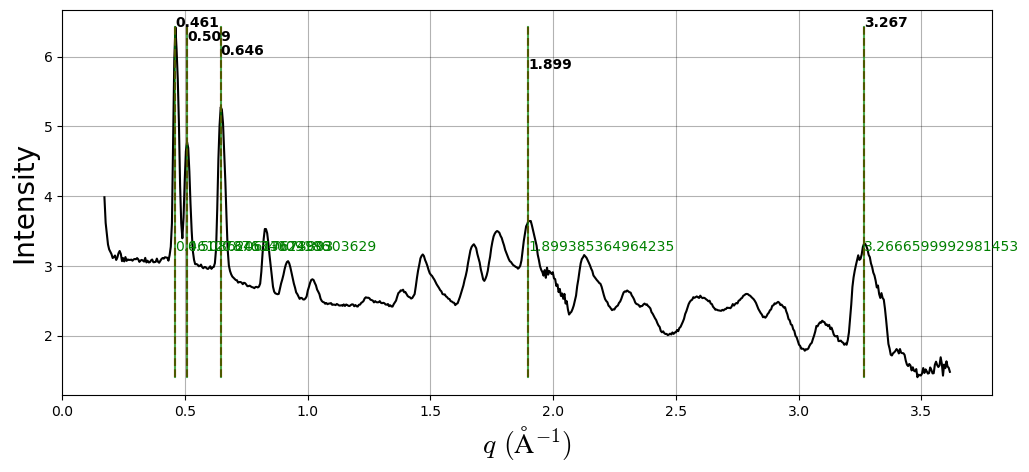

In [281]:
### Show one curve and find peaks

#protocol = 'circular_average'
protocol = list(exp.dict['analysis'].keys())[-1]
print(protocol)
print(exp.dict['rawinfo']['filename'][-1])

## Pick a curve
file_idx = -1
line_plot = DataLine(x = exp.dict['analysis'][protocol]['q'], y = exp.dict['analysis'][protocol]['I_stack'][file_idx])  
flag_log = 1

%matplotlib inline
#%matplotlib ipympl
plt.figure(1, figsize=(12,5)); plt.clf()
q_peaks = Tools.plot_peaks(line_plot, N_peaks_find = 5, fit_param=[0, 1, 0.001], flag_log=flag_log, line_color='k', label_color='r', verbose=1)  #Tools.rand_color(0.5, 0.8)

# q_label = [0.1076]
for q in q_label:
    if flag_log:
        y_range = [min(np.log(line_plot.y)), max(np.log(line_plot.y))]
    else:
        y_range = [min(line_plot.y), max(np.log(line_plot.y))]
    plt.plot([q, q], y_range, 'g',  alpha=0.7)
    plt.text(q, y_range[1]/2, str(q), color='g')

plt.xlabel(r'$q$ $({\rm \AA}^{-1})$', size=20)
plt.ylabel('Intensity', size=20)

##### - __Plot all curves as 2D image__

q_label = [0.46127876 0.50862062 0.64573625 1.89938536 3.26666   ]


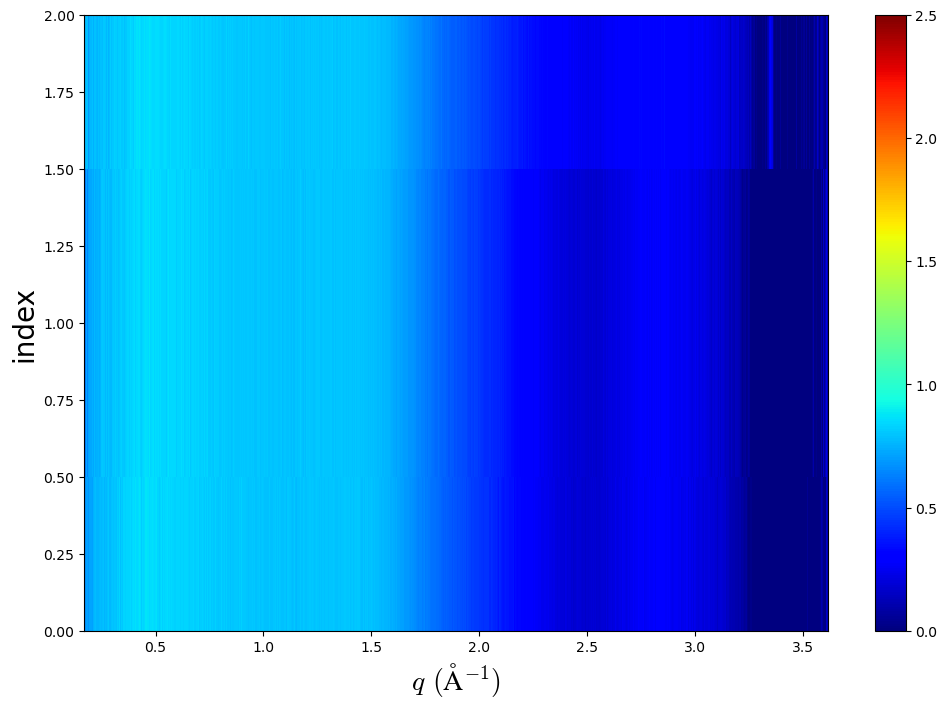

In [280]:
q_label = q_peaks #[1.278, 1.88, 2.219, 2.564, 2.905]; # Label the lines
flag_log = True

#protocol = 'circular_average'
protocol = list(exp.dict['analysis'].keys())[-1]


x_axis = exp.dict['analysis'][protocol]['q'] 
I_stack = exp.dict['analysis'][protocol]['I_stack']
# y_axis = exp.dict['metadata']['scan_id'] - exp.dict['metadata']['scan_id'][0]
# y_axis = exp.dict['metadata']['sample_clock'] #- exp.dict['metadata']['sample_clock'][0]

y_axis = np.arange(len(infiles))
if flag_log:
    I_stack = np.log10(I_stack)
    
%matplotlib inline
plt.figure(2, figsize=(12,8)); plt.clf()
# plt.imshow(I_stack, origin='lower', cmap='jet', extent = [np.min(x_axis), np.max(x_axis), scan_id[0], scan_id[-1]],  aspect='auto') #aspect='auto' 0.005
# # plt.imshow(I_stack, origin='lower', cmap='jet', extent = [np.min(x_axis), np.max(x_axis), 0, I_stack.shape[0]],  aspect='auto') #aspect='auto' 0.005
# cbar = plt.colorbar(fraction=0.02, pad=0.02, aspect=40) 

# y_axis = np.arange(0, I_stack.shape[0])
X, Y = np.meshgrid(x_axis, y_axis)
#dont know how to change the plotting range in pcolormesh
# plt.pcolormesh(X,Y,I_stack,vmin=.3,vmax=2.8, cmap=mpl.cm.jet); plt.colorbar()
plt.pcolormesh(X,Y,I_stack, cmap=mpl.cm.jet); plt.colorbar()
plt.xlabel(r'$q$ $({\rm \AA}^{-1})$', size=20)
plt.ylabel('index', size=20)
# plt.ylabel('Time (s)')
# plt.xlim(-.2, .2)
plt.ylim(0, 2)
plt.clim(0, 2.5)

print('q_label = {}'.format(q_label))
#for q in q_label:
#    plt.plot([q, q], [0, I_stack.shape[0]], 'k',  alpha=0.2)
    

q_label = [0.46127876 0.50862062 0.64573625 1.89938536 3.26666   ]


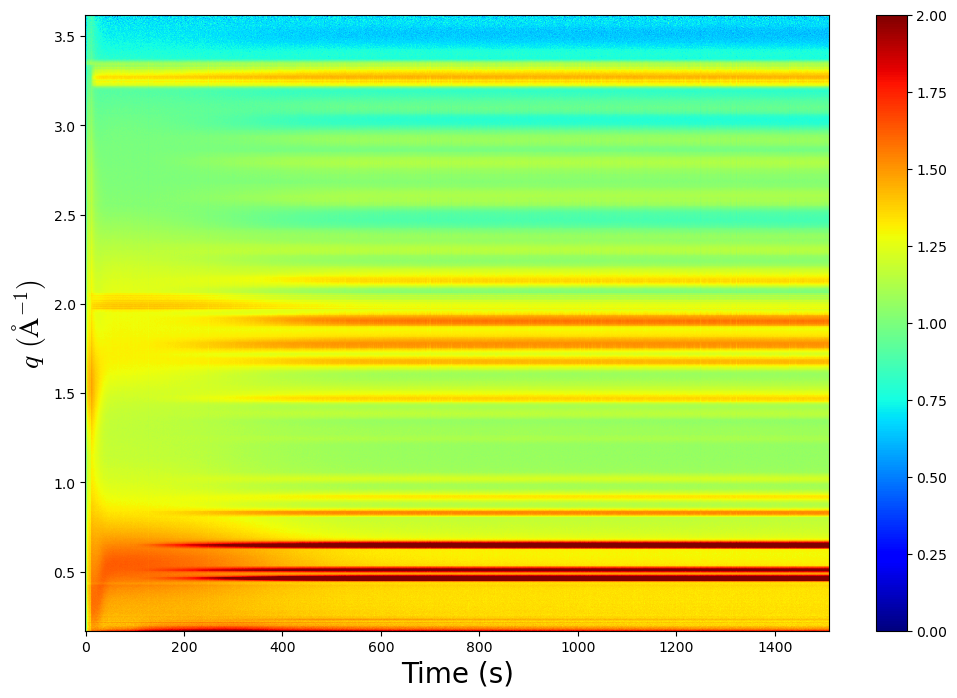

In [345]:
q_label = q_peaks #[1.278, 1.88, 2.219, 2.564, 2.905]; # Label the lines
flag_log = True

#protocol = 'circular_average'
protocol = list(exp.dict['analysis'].keys())[-1]


x_axis = exp.dict['analysis'][protocol]['q'] 
I_stack = exp.dict['analysis'][protocol]['I_stack']
# y_axis = exp.dict['metadata']['scan_id'] - exp.dict['metadata']['scan_id'][0]
# y_axis = exp.dict['metadata']['sample_clock'] #- exp.dict['metadata']['sample_clock'][0]

exposure_period = 0.5
y_axis = np.arange(len(infiles))*exposure_period
if flag_log:
    I_stack = np.log10(I_stack)
    
%matplotlib inline
plt.figure(2, figsize=(12,8)); plt.clf()
# plt.imshow(I_stack, origin='lower', cmap='jet', extent = [np.min(x_axis), np.max(x_axis), scan_id[0], scan_id[-1]],  aspect='auto') #aspect='auto' 0.005
# # plt.imshow(I_stack, origin='lower', cmap='jet', extent = [np.min(x_axis), np.max(x_axis), 0, I_stack.shape[0]],  aspect='auto') #aspect='auto' 0.005
# cbar = plt.colorbar(fraction=0.02, pad=0.02, aspect=40) 

# y_axis = np.arange(0, I_stack.shape[0])
X, Y = np.meshgrid( y_axis, x_axis)
#dont know how to change the plotting range in pcolormesh
# plt.pcolormesh(X,Y,I_stack,vmin=.3,vmax=2.8, cmap=mpl.cm.jet); plt.colorbar()
plt.pcolormesh(X,Y,I_stack.T, cmap=mpl.cm.jet, 
               vmin=np.percentile(I_stack, 0),
               vmax=np.percentile(I_stack, 100)) #, vmin=0.2,vmax=2.3); 
plt.colorbar()
plt.ylabel(r'$q$ $({\rm \AA}^{-1})$', size=20)
plt.xlabel('Time (s)', size=20)
# plt.ylabel('Time (s)')
# plt.xlim(-.2, .2)
# plt.ylim(0.3, 3)
plt.clim(0, 2)

print('q_label = {}'.format(q_label))
#for q in q_label:
#    plt.plot([q, q], [0, I_stack.shape[0]], 'k',  alpha=0.2)
    

#### &#9642; __Plot curves__

##### - __Load one curve & find peaks__

circular_average
sam22_1mai1pbi2_dmso_1m_5scfh_Si_40uL_013*
fit_param = [height, width, prominence]
5 peaks found: [0.4613 0.5086 0.6457 1.8994 3.2667] for fit_prom 0.85943


Text(0, 0.5, 'Intensity')

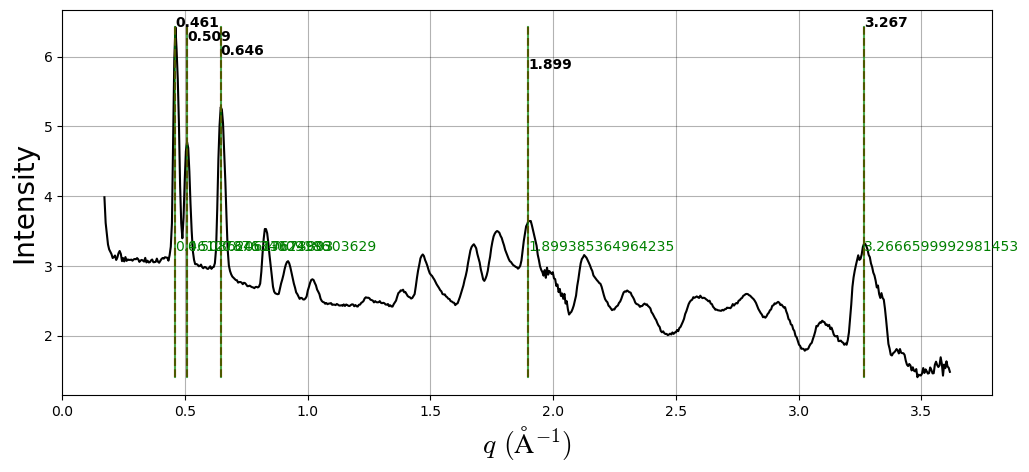

In [344]:
### Show one curve and find peaks

#protocol = 'circular_average'
protocol = list(exp.dict['analysis'].keys())[-1]
print(protocol)
print(exp.dict['rawinfo']['filename'][-1])

## Pick a curve
file_idx = -1
line_plot = DataLine(x = exp.dict['analysis'][protocol]['q'], y = exp.dict['analysis'][protocol]['I_stack'][file_idx])  
flag_log = 1

%matplotlib inline
#%matplotlib ipympl
plt.figure(1, figsize=(12,5)); plt.clf()
q_peaks = Tools.plot_peaks(line_plot, N_peaks_find = 5, fit_param=[0, 1, 0.001], flag_log=flag_log, line_color='k', label_color='r', verbose=1)  #Tools.rand_color(0.5, 0.8)

# q_label = [0.1076]
for q in q_label:
    if flag_log:
        y_range = [min(np.log(line_plot.y)), max(np.log(line_plot.y))]
    else:
        y_range = [min(line_plot.y), max(np.log(line_plot.y))]
    plt.plot([q, q], y_range, 'g',  alpha=0.7)
    plt.text(q, y_range[1]/2, str(q), color='g')

plt.xlabel(r'$q$ $({\rm \AA}^{-1})$', size=20)
plt.ylabel('Intensity', size=20)

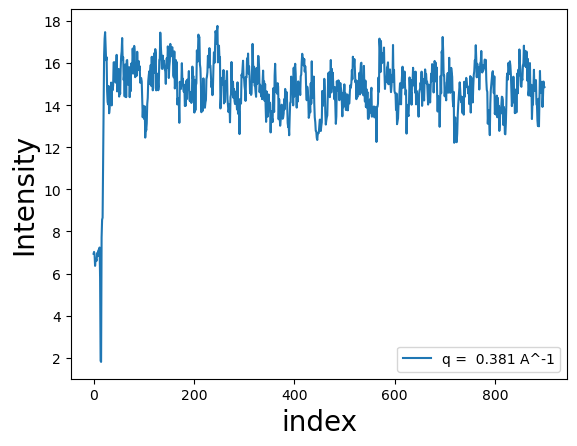

In [224]:
peak_num = 2

x_axis = exp.dict['analysis'][protocol]['q'] 
I_stack = exp.dict['analysis'][protocol]['I_stack']

I_peak = I_stack[:, np.where(x_axis == q_peaks[peak_num])[0]]
idx = np.arange(len(I_peak))

fig,ax = plt.subplots()
ax.plot(idx, I_peak, label = f'q = {q_peaks[peak_num]: .3} A^-1')
ax.set_xlabel('index', size=20)
ax.set_ylabel('Intensity', size=20)
ax.set
ax.legend()

#### &#9642; __Extract 0D feature & Plot 1D__

##### - __Load one curve for peak fitting__

{'fit_peaks_b': {'error': 0.5219096328112973, 'value': 3.4410124187595836},
 'fit_peaks_chi_squared': 0.008929368382923275,
 'fit_peaks_d0': {'error': 0.0005245290288040681, 'value': 0.9675329379750915},
 'fit_peaks_d01': {'error': 0.0005245290288040681, 'value': 0.9675329379750915},
 'fit_peaks_grain_size': {'error': 0.6335252122827814,
                          'value': 19.387512245111783},
 'fit_peaks_grain_size1': {'error': 0.6335252122827814,
                           'value': 19.387512245111783},
 'fit_peaks_m': {'error': 0.8162837210160984, 'value': -0.866534941581298},
 'fit_peaks_prefactor1': {'error': 0.059143730768499686,
                          'value': 2.480836403295429},
 'fit_peaks_prefactor_total': 2.480836403295429,
 'fit_peaks_qalpha': {'error': 0, 'value': 1.0},
 'fit_peaks_qp': {'error': 0, 'value': 0},
 'fit_peaks_sigma1': {'error': 0.00042248341701353007,
                      'value': 0.012929086738619611},
 'fit_peaks_x_center1': {'error': 0.00035206096825455

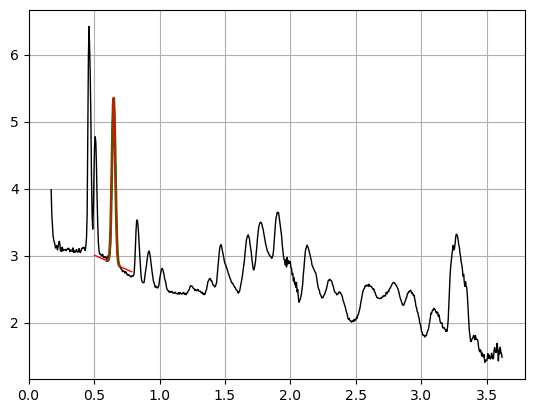

In [288]:
### Show one curve & do fitting
protocol = 'circular_average'

file_idx = -1
line_plot = DataLine(x = exp.dict['analysis'][protocol]['q'], y = exp.dict['analysis'][protocol]['I_stack'][file_idx])  

q0 = [0.646] #[2.64964595, 3.07210364] #[1.82, 1.86]
fit_range =  [q0[0] -.05, q0[0] +0.05] #[2.5, 3.2] #[1.7, 1.95]

# q0 = [0.381] #[2.64964595, 3.07210364] #[1.82, 1.86]
# fit_range = [0.33, 0.45] #[2.5, 3.2] #[1.7, 1.95]

flag_log = True
if flag_log == 1:
    line_plot.y = np.log(line_plot.y)

## Fitting
run_args = { 'verbosity' : 3,
             #'fittype': 'voigt',
            }
results = {}
protocol = Protocols.fit_peaks()
lines = protocol._fit(line_plot, results, **run_args, q0=q0, num_curves=len(q0), fit_range=fit_range)

plt.figure(10); plt.clf()
for nn, line in enumerate(lines.lines):
        
    if nn==0: 
        plt.plot(line.x, line.y, 'k', linewidth=1, label=line.name)
        plt.title(line.name)
    elif nn==1:
        plt.plot(line.x, line.y, 'g', linewidth=2, label=line.name)
    else:
        plt.plot(line.x, line.y, 'r', linewidth=1, label=line.name)
        
    plt.grid()

    # plt.legend()
pprint.pprint(lines.results)

In [284]:
fit_range

[0.461, -0.05, 0.05]

##### - __Apply fitting for all__

In [303]:
protocol = 'circular_average'
q0 = [0.646, 2] #[2.64964595, 3.07210364] #[1.82, 1.86]
fit_range = [0.60, 0.70, 1.8, 2.2] #[1.7, 1.95]


## Fitting
run_args = { 'verbosity' : 3,
             #'fittype': 'voigt',
            }
p = Protocols.fit_peaks()
    

## Fitting all curves
#0.646, 2
peak_x1 = []
peak_x2 = []
peak_pre1 = []
peak_y = []
t0 = time.time()
plt.figure(10); plt.clf()

for ii in np.arange(Nfiles):
    line_plot = DataLine(x = exp.dict['analysis'][protocol]['q'], y = exp.dict['analysis'][protocol]['I_stack'][ii])  
    
    lines = p._fit(line_plot, results={}, **run_args, q0=q0, num_curves=len(q0), fit_range=fit_range)

    peak_x1.append(lines.results['fit_peaks_x_center1']['value'])
    #peak_x2.append(lines.results['fit_peaks_x_center2']['value'])
    peak_pre1.append(lines.results['fit_peaks_prefactor1']['value'])
    peak_y.append(lines.lines[1].target_y_max()[1])
    peak_x2.append(lines.results['fit_peaks_x_center2']['value'])

print('Fitting took {:.0f}s\n'.format(time.time()-t0))

plt.show()
#Ts = exp.dict['metadata']['sample_temperature_D']
#scan_ids = exp.dict['rawinfo']['scan_id']


Fitting took 51s



<Figure size 640x480 with 0 Axes>

In [311]:
len(y_axis)

3022

In [316]:
y_axis

array([   0,    1,    2, ..., 3019, 3020, 3021])

##### - __Plot peak position and peak intensity from fitting__

Text(0, 0.5, 'Peak intensity')

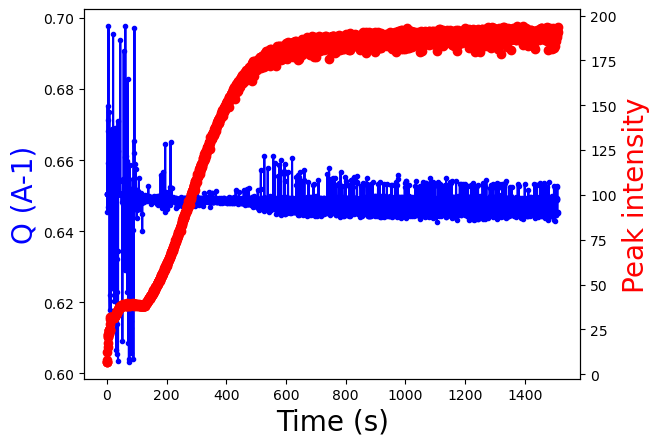

In [323]:
fig,ax = plt.subplots()

ax.plot(y_axis*.5, peak_x1, '.-b')
ax.set_ylabel('Q (A-1)', color = 'b', size=20)
ax.set_xlabel('Time (s)', size=20)

ax2 = ax.twinx()
ax2.plot(y_axis*.5, peak_y, 'r-o')
ax2.set_ylabel('Peak intensity', color = 'r', size=20)

Text(0.5, 0, 'Time (s)')

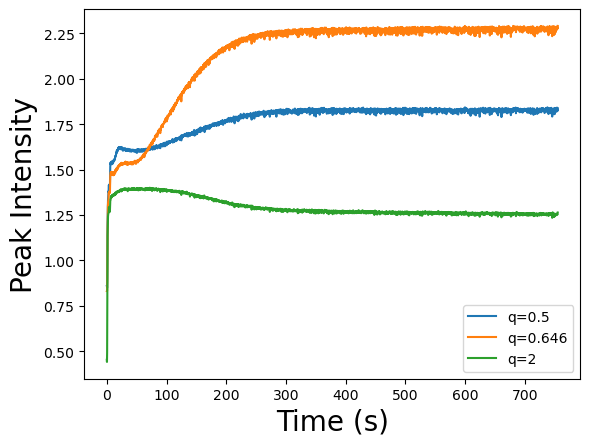

In [347]:
### Get the q with max intensity within this range

target_q = [0.5, 0.646, 2]

Fig,ax = plt.subplots()

for q in target_q:
    closest_index = np.argmin(np.abs(x_axis-q))
    target_I = I_stack.T[closest_index]

    ax.plot(y_axis*.5, target_I, label='q={}'.format(q))
    ax.legend()#, size=20)
    
ax.set_ylabel('Peak Intensity', size=20)
ax.set_xlabel('Time (s)', size=20)

# y_axis = line_x

# q_peakmax_list = []
# data_show = []
# for ii in np.arange(len(y)):
#     line_y = y[ii]
#     line_y_crop = line_y[idx_min:idx_max]
#     line_x_crop = x_axis[idx_min:idx_max]
#     q_peakmax = line_x_crop[np.argmax(line_y_crop)]
#     q_peakmax_list.append(q_peakmax)
#     data_show.append([Ts[ii], scan_ids[ii], q_peakmax])

# df_line_s = pd.DataFrame(q_peakmax_list, columns=['I'])
# df_show = pd.DataFrame(data_show, columns = ['RH', 'scan_id', 'q_peakmax'])

# print(q_peakmax_list[0:5])

Text(0, 0.5, 'Peak intensity')

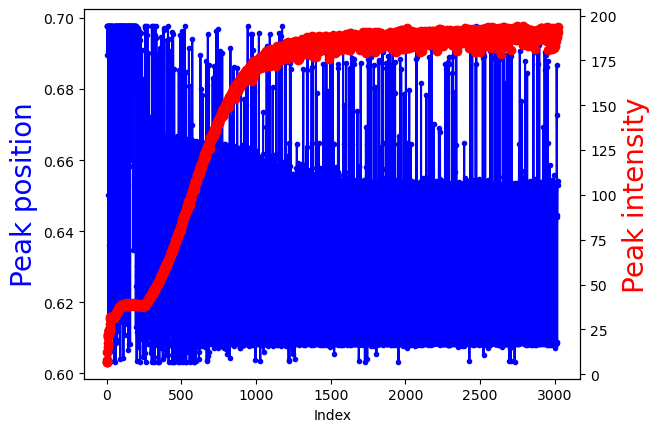

In [305]:
fig,ax = plt.subplots()

ax.plot(peak_xx, '.-b')
ax.set_ylabel('Peak position', color = 'b', size=20)
ax.set_xlabel('Index')

ax2 = ax.twinx()
ax2.plot(peak_y, 'r-o')
ax2.set_ylabel('Peak intensity', color = 'r', size=20)

In [ ]:
# exp.dict['analysis']['circular_average']['fit_peaks_x_center1'] = peak_x1
# #exp.dict['analysis']['circular_average']['fit_peaks_x_center2'] = peak_x2
# exp.show()

In [ ]:
# #Convert list or dict to dataframe:
# df_list = pd.DataFrame(peak_x1, columns=['peak_x1'])
